In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error
import matplotlib.pyplot as plt
from data_preprocessing import load_xgboost_data 
# Load Data
FILE_PATH = r'C:\nano_optics_ml_data\processed\article_main_data.csv'


In [4]:
# Load the data
X_train, X_test, y_train, y_test, scaler_X, scaler_y = load_xgboost_data(FILE_PATH)

# Train XGBoost Model for Real & Imaginary parts separately
xgb_real = XGBRegressor(n_estimators=888, learning_rate=0.049, max_depth=6, random_state=42)
xgb_imag = XGBRegressor(n_estimators=888, learning_rate=0.049, max_depth=6, random_state=42)

xgb_real.fit(X_train, y_train[:, 0])  # Real part
xgb_imag.fit(X_train, y_train[:, 1])  # Imaginary part

# Make predictions
y_pred_real = xgb_real.predict(X_test)
y_pred_imag = xgb_imag.predict(X_test)

# Combine real and imaginary parts
y_pred_xgb = np.column_stack([y_pred_real, y_pred_imag])

# Inverse transform to original scale
y_pred_xgb_original = scaler_y.inverse_transform(y_pred_xgb)
y_test_original = scaler_y.inverse_transform(y_test)

# Compute RMSE
rmse_xgb = (root_mean_squared_error(y_test_original, y_pred_xgb_original))
print(f"XGBoost RMSE: {rmse_xgb:.4f}")


XGBoost RMSE: 0.1469


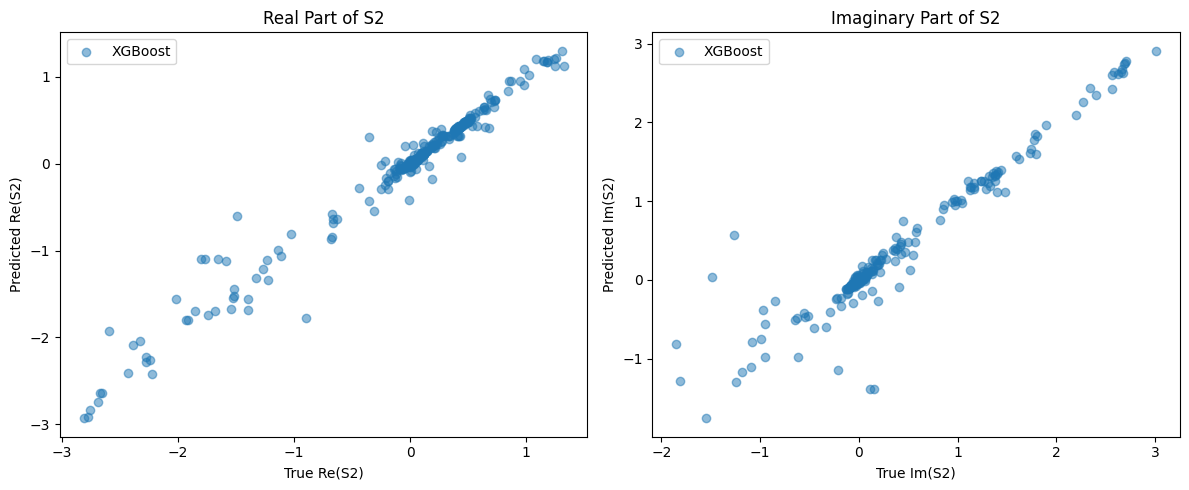

In [5]:
# Plot real part
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test_original[:, 0], y_pred_xgb_original[:, 0], label="XGBoost", alpha=0.5)

plt.xlabel("True Re(S2)")
plt.ylabel("Predicted Re(S2)")
plt.title("Real Part of S2")
plt.legend()

# Plot imaginary part
plt.subplot(1, 2, 2)
plt.scatter(y_test_original[:, 1], y_pred_xgb_original[:, 1], label="XGBoost", alpha=0.5)
plt.xlabel("True Im(S2)")
plt.ylabel("Predicted Im(S2)")
plt.title("Imaginary Part of S2")
plt.legend()

plt.tight_layout()
plt.show()


In [104]:

def objective(trial):
    # Sample hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 2000),
        'max_depth': trial.suggest_int('max_depth', 2, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.9),
        # 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        # 'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        # 'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    X_train, X_test, y_train, y_test, scaler_X, scaler_y = load_xgboost_data(FILE_PATH)
    model_real = XGBRegressor(**params)
    model_imag = XGBRegressor(**params)

    model_real.fit(X_train, y_train[:, 0])
    model_imag.fit(X_train, y_train[:, 1])

    y_pred_real = model_real.predict(X_test)
    y_pred_imag = model_imag.predict(X_test)
    y_pred = np.column_stack((y_pred_real, y_pred_imag))
    y_test_original = scaler_y.inverse_transform(y_test)
    y_pred_original = scaler_y.inverse_transform(y_pred)

    # Use RMSE as the metric
    rmse = root_mean_squared_error(y_test_original, y_pred_original)
    return rmse

In [106]:
import optuna

study = optuna.create_study(direction='minimize')  # We want to minimize RMSE
study.optimize(objective, n_trials=1000, n_jobs=6)  # Try 30 different combinations

# Best hyperparameters
print("Best RMSE:", study.best_value)
print("Best Hyperparameters:", study.best_params)

[I 2025-03-25 10:20:45,655] A new study created in memory with name: no-name-54ad50ff-1dad-4b8d-9e32-949831546b34
[I 2025-03-25 10:20:47,245] Trial 2 finished with value: 0.13107560575008392 and parameters: {'n_estimators': 603, 'max_depth': 30, 'learning_rate': 0.8041256300653052}. Best is trial 2 with value: 0.13107560575008392.
[I 2025-03-25 10:20:47,431] Trial 5 finished with value: 0.12760740518569946 and parameters: {'n_estimators': 998, 'max_depth': 8, 'learning_rate': 0.36668229357921905}. Best is trial 5 with value: 0.12760740518569946.
[I 2025-03-25 10:20:47,883] Trial 6 finished with value: 0.13596174120903015 and parameters: {'n_estimators': 198, 'max_depth': 15, 'learning_rate': 0.8653825827895085}. Best is trial 5 with value: 0.12760740518569946.
[I 2025-03-25 10:20:48,016] Trial 0 finished with value: 0.12557509541511536 and parameters: {'n_estimators': 543, 'max_depth': 32, 'learning_rate': 0.36130394397010834}. Best is trial 0 with value: 0.12557509541511536.
[I 2025-0

Best RMSE: 0.10214947909116745
Best Hyperparameters: {'n_estimators': 188, 'max_depth': 6, 'learning_rate': 0.029232952878804595}


In [29]:
best_params = study.best_params

X_train, X_test, y_train, y_test, scaler_X, scaler_y = load_xgboost_data(FILE_PATH)

final_model_real = XGBRegressor(**best_params)
final_model_imag = XGBRegressor(**best_params)

final_model_real.fit(X_train, y_train[:, 0])
final_model_imag.fit(X_train, y_train[:, 1])


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.961968562447948, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.023931948188138184,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=287, n_jobs=None,
             num_parallel_tree=None, ...)